In [2]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

%matplotlib inline

In [3]:
# Here you run your code to explore the data
conn = sqlite3.connect('data\movies.db')
cur = conn.cursor()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [4]:
# Here you run your code to clean the data

First joining `tn_movie_budgets` with `imdb_movie_basics`

In [126]:
cur.execute("""SELECT b.movie, b.production_budget, b.domestic_gross, b.worldwide_gross, m.genres 
               FROM tn_movie_budgets b
               JOIN imdb_title_basics m
               ON b.movie = m.primary_title
               GROUP BY movie
               ORDER BY worldwide_gross DESC;""")
gross_df = pd.DataFrame(cur.fetchall())
gross_df.columns = [x[0] for x in cur.description]
gross_df

,movie,production_budget,domestic_gross,worldwide_gross,genres
0,Duma,"$12,000,000","$870,067","$994,790","Biography,Crime,Documentary"
1,Insidious,"$1,500,000","$54,009,150","$99,870,886","Horror,Mystery,Thriller"
2,Hellboy,"$60,000,000","$59,623,958","$99,823,958","Action,Adventure,Fantasy"
3,Alpha,"$51,000,000","$35,851,379","$99,624,873","Adventure,Drama,Family"
4,Hitman,"$24,000,000","$39,687,694","$99,135,571",Action
...,...,...,...,...,...
2307,A Fine Step,"$1,000,000",$0,$0,Drama
2308,8 Days,"$2,500,000",$0,$0,"Drama,Thriller"
2309,40 Weeks,"$900,000",$0,$0,Documentary
2310,1982,"$1,000,000",$0,$0,Documentary


In [127]:
gross_df['split_genres'] = gross_df['genres'].str.split(',')
gross_df = gross_df.dropna(subset = ['genres'])

In [133]:
type(gross_df['domestic_gross'].iloc[0])

str

In [128]:
gross_df = gross_df.explode('split_genres')
gross_df

,movie,production_budget,domestic_gross,worldwide_gross,genres,split_genres
0,Duma,"$12,000,000","$870,067","$994,790","Biography,Crime,Documentary",Biography
0,Duma,"$12,000,000","$870,067","$994,790","Biography,Crime,Documentary",Crime
0,Duma,"$12,000,000","$870,067","$994,790","Biography,Crime,Documentary",Documentary
1,Insidious,"$1,500,000","$54,009,150","$99,870,886","Horror,Mystery,Thriller",Horror
1,Insidious,"$1,500,000","$54,009,150","$99,870,886","Horror,Mystery,Thriller",Mystery
...,...,...,...,...,...,...
2309,40 Weeks,"$900,000",$0,$0,Documentary,Documentary
2310,1982,"$1,000,000",$0,$0,Documentary,Documentary
2311,#Horror,"$1,500,000",$0,$0,"Crime,Drama,Horror",Crime
2311,#Horror,"$1,500,000",$0,$0,"Crime,Drama,Horror",Drama


when splitting genres, be careful with economic data because I don't want to add up the duplicate values for each movie and then say "this was the total budget for that movie", etc

Creating IMDB ratings data frame

In [115]:
cur.execute("""SELECT m.primary_title, r.averagerating, r.numvotes, m.genres
               FROM imdb_title_basics m
               JOIN imdb_title_ratings r
               USING(tconst);""")
ratings_df = pd.DataFrame(cur.fetchall())
ratings_df.columns = [x[0] for x in cur.description]
ratings_df

,primary_title,averagerating,numvotes,genres
0,Sunghursh,7.0,77,"Action,Crime,Drama"
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama"
2,The Other Side of the Wind,6.9,4517,Drama
3,Sabse Bada Sukh,6.1,13,"Comedy,Drama"
4,The Wandering Soap Opera,6.5,119,"Comedy,Drama,Fantasy"
...,...,...,...,...
73851,Diabolik sono io,6.2,6,Documentary
73852,Sokagin Çocuklari,8.7,136,"Drama,Family"
73853,Albatross,8.5,8,Documentary
73854,La vida sense la Sara Amat,6.6,5,None


Splitting genres for each movie

In [116]:
ratings_df['split_genres'] = ratings_df['genres'].str.split(',')
ratings_df

,primary_title,averagerating,numvotes,genres,split_genres
0,Sunghursh,7.0,77,"Action,Crime,Drama","[Action, Crime, Drama]"
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama","[Biography, Drama]"
2,The Other Side of the Wind,6.9,4517,Drama,[Drama]
3,Sabse Bada Sukh,6.1,13,"Comedy,Drama","[Comedy, Drama]"
4,The Wandering Soap Opera,6.5,119,"Comedy,Drama,Fantasy","[Comedy, Drama, Fantasy]"
...,...,...,...,...,...
73851,Diabolik sono io,6.2,6,Documentary,[Documentary]
73852,Sokagin Çocuklari,8.7,136,"Drama,Family","[Drama, Family]"
73853,Albatross,8.5,8,Documentary,[Documentary]
73854,La vida sense la Sara Amat,6.6,5,None,None


In [117]:
ratings_df = ratings_df.dropna(subset = ['genres'])

In [118]:
ratings_df = ratings_df.explode('split_genres')
ratings_df

,primary_title,averagerating,numvotes,genres,split_genres
0,Sunghursh,7.0,77,"Action,Crime,Drama",Action
0,Sunghursh,7.0,77,"Action,Crime,Drama",Crime
0,Sunghursh,7.0,77,"Action,Crime,Drama",Drama
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama",Biography
1,One Day Before the Rainy Season,7.2,43,"Biography,Drama",Drama
...,...,...,...,...,...
73851,Diabolik sono io,6.2,6,Documentary,Documentary
73852,Sokagin Çocuklari,8.7,136,"Drama,Family",Drama
73852,Sokagin Çocuklari,8.7,136,"Drama,Family",Family
73853,Albatross,8.5,8,Documentary,Documentary


I also wanted to observe common combinations of movie genres, so I filtered out movie genres with less than 500 movie under those genres and created a new data frame for the filtered movie list

In [122]:
x_df = ratings_df.groupby('genres').count().iloc[:,0]
x2_df = x_df[x_df >= 500].index
combined_ratings_df = ratings_df[ratings_df.genres.isin(x2_df)]
combined_ratings_df.groupby('genres').mean().head()

,averagerating,numvotes
genres,,
Action,5.757712,336.115424
"Action,Adventure,Animation",6.562874,21380.497006
"Action,Adventure,Comedy",5.554032,29260.830645
"Action,Adventure,Drama",5.691579,23607.594737
"Action,Comedy",5.748936,3020.492401


Creating data frame for Rotten Tomatoes data

In [13]:
cur.execute("""SELECT movie_title, genres, tomatometer_status, tomatometer_rating, tomatometer_count, audience_status, audience_rating, audience_count
               FROM rotten_tomatoes_movies;""")
rotten_tomatoes_df = pd.DataFrame(cur.fetchall())
rotten_tomatoes_df.columns = [x[0] for x in cur.description]
rotten_tomatoes_df.head(5)

,movie_title,genres,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count
0,Percy Jackson & the Olympians: The Lightning T...,"Action & Adventure, Comedy, Drama, Science Fic...",Rotten,49.0,149.0,Spilled,53.0,254421.0
1,Please Give,Comedy,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0
2,10,"Comedy, Romance",Fresh,67.0,24.0,Spilled,53.0,14684.0
3,12 Angry Men (Twelve Angry Men),"Classics, Drama",Certified-Fresh,100.0,54.0,Upright,97.0,105386.0
4,"20,000 Leagues Under The Sea","Action & Adventure, Drama, Kids & Family",Fresh,89.0,27.0,Upright,74.0,68918.0


## Data Visualization

Average ratings by genre, for genre categories with more than 500 entries

[Text(0, 0, 'Action'),
 Text(1, 0, 'Action,Adventure,Animation'),
 Text(2, 0, 'Action,Adventure,Comedy'),
 Text(3, 0, 'Action,Adventure,Drama'),
 Text(4, 0, 'Action,Comedy'),
 Text(5, 0, 'Action,Comedy,Crime'),
 Text(6, 0, 'Action,Comedy,Drama'),
 Text(7, 0, 'Action,Crime,Drama'),
 Text(8, 0, 'Action,Crime,Thriller'),
 Text(9, 0, 'Action,Drama'),
 Text(10, 0, 'Action,Drama,Thriller'),
 Text(11, 0, 'Action,Thriller'),
 Text(12, 0, 'Adventure,Animation,Comedy'),
 Text(13, 0, 'Biography,Documentary'),
 Text(14, 0, 'Biography,Documentary,Drama'),
 Text(15, 0, 'Biography,Documentary,History'),
 Text(16, 0, 'Biography,Documentary,Music'),
 Text(17, 0, 'Biography,Drama,History'),
 Text(18, 0, 'Comedy'),
 Text(19, 0, 'Comedy,Crime,Drama'),
 Text(20, 0, 'Comedy,Drama'),
 Text(21, 0, 'Comedy,Drama,Family'),
 Text(22, 0, 'Comedy,Drama,Romance'),
 Text(23, 0, 'Comedy,Horror'),
 Text(24, 0, 'Comedy,Romance'),
 Text(25, 0, 'Crime,Drama'),
 Text(26, 0, 'Crime,Drama,Mystery'),
 Text(27, 0, 'Crime,Dram

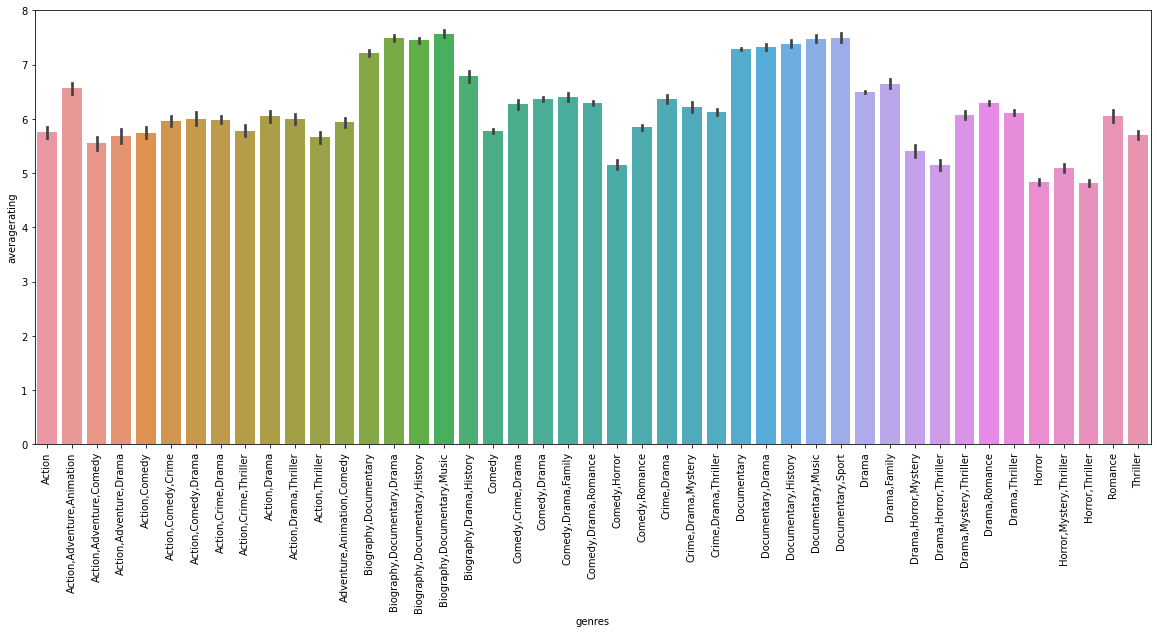

In [114]:
f, ax = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='genres', y='averagerating', data=combined_ratings_df,
                order=x2_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, 'Action'),
 Text(1, 0, 'Crime'),
 Text(2, 0, 'Drama'),
 Text(3, 0, 'Comedy'),
 Text(4, 0, 'Horror'),
 Text(5, 0, 'Thriller'),
 Text(6, 0, 'Adventure'),
 Text(7, 0, 'Animation'),
 Text(8, 0, 'Documentary'),
 Text(9, 0, 'History'),
 Text(10, 0, 'Mystery'),
 Text(11, 0, 'Family'),
 Text(12, 0, 'Romance'),
 Text(13, 0, 'Biography'),
 Text(14, 0, 'Music'),
 Text(15, 0, 'Sport')]

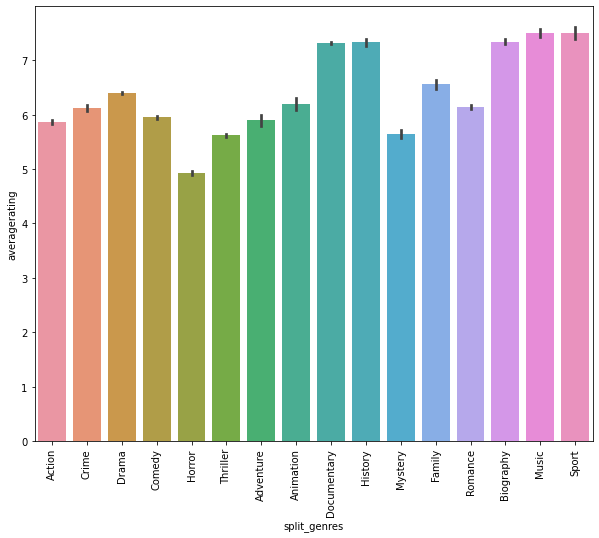

In [121]:
f, ax = plt.subplots(figsize=(10,8))
ax = sns.barplot(x='split_genres', y='averagerating', data=combined_ratings_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

<AxesSubplot:xlabel='tomatometer_count', ylabel='tomatometer_rating'>

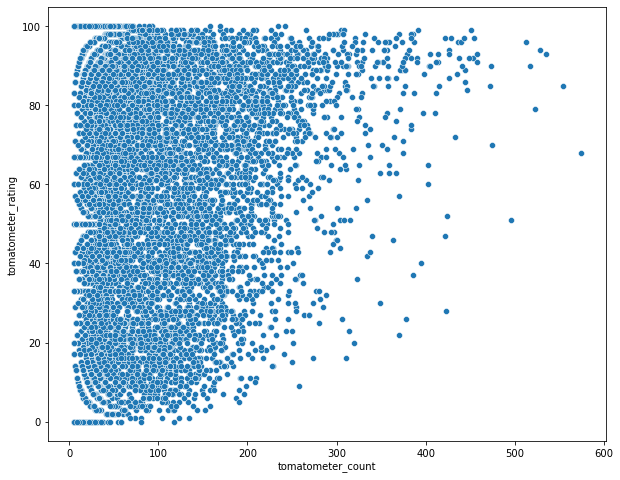

In [135]:
f, ax = plt.subplots(figsize=(10,8))
sns.scatterplot(x="tomatometer_count", y="tomatometer_rating", data=rotten_tomatoes_df)